**Objetivo**: Carregar e testar a rede neural treinada


In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
PATH = '/content/gdrive/Shareddrives/IA901 - Projeto Final/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
# Criando pasta para salvar resultados preliminares/finais

PATHFinal = PATH+'Notebooks/FinalResults/TissueClassification/'

if not os.path.exists(PATHFinal):
  os.mkdir(PATHFinal)

In [54]:
# ______________________________________________________________________________
# Pegando resultados do experimento escolhido

print('Lista de experimentos disponíveis: ', os.listdir(PATH+"Notebooks/InterimResults/TissueClassification/"))
print('Diga o numero do experimento que você gostaria de carregar (Experiment_Name)')
ExperimentName = str (input()) # por ex. 'DL_Baseline'

path_interim = PATH+"Notebooks/InterimResults/TissueClassification/{}".format(ExperimentName)

print('Lista de subexperimentos disponíveis: ', os.listdir(path_interim)[1:])
print('Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)')
Experiment_Number = str (input())
subpath = path_interim+'/{}'.format(Experiment_Number)

data_dir = PATH+'Datasets/Processed/TissueClassification/{}'.format(ExperimentName)

Lista de experimentos disponíveis:  ['Experiment_I', 'Experiment_II', 'Experiment_III', 'Experiment_IV']
Diga o numero do experimento que você gostaria de carregar (Experiment_Name)
Experiment_IV
Lista de subexperimentos disponíveis:  ['1']
Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)
1


In [55]:
PATHFinalExperiment = PATHFinal+'{}/'.format(ExperimentName)

if not os.path.exists(PATHFinalExperiment):
  os.mkdir(PATHFinalExperiment)

# Configurações gerais e funções úteis para as análises

In [56]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import re
plt.ion()   # interactive mode

!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [58]:
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd

def AnalysisPlots(classe_teste, PrevisoesProb):

  # Construindo a ROC Curve
  # A função abaixo retorna arrays de True Positive Rate (TPR), False Positive Rate (FPR) e os valores de threshold
  FPR, TPR, thresholds = metrics.roc_curve(classe_teste, PrevisoesProb, drop_intermediate=False)

  # Calculo da AUC
  auc = metrics.roc_auc_score(classe_teste, PrevisoesProb)

  # Plotando ROC Curve com matplotlib:
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(FPR, TPR, label="AUC ="+np.format_float_positional(auc, precision=3))
  ax.plot([0,1], [0,1], linestyle='--', label='Random Selection, AUC = 0.5')
  ax.set_xlabel('False Positive Rate', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('ROC Curve', fontsize=15)
  ax.grid()
  ax.legend(loc='lower right')
  plt.savefig(PATHFinalExperiment+'/ROC.png')
  plt.show()

  plt.clf() # limpando janela de plot

  # Plot TPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, TPR)
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('TPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(PATHFinalExperiment+'/TPRxThreshold.png')
  plt.show()

  plt.clf() # limpando janela de plot

  # Plot FPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, FPR)
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('False Positive Rate', fontsize=15)
  ax.set_title('FPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(PATHFinalExperiment+'/FPRxThreshold.png')
  plt.show()


  plt.clf() # limpando janela de plot

  # Dataframe com indice de Youden:
  DataFrameYouden = pd.DataFrame(data={'Threshold':thresholds,'Youden':TPR - FPR})

  # Dataframe com indice maximo de Youden:
  DataFrameYoudenMax = DataFrameYouden.sort_values(by='Youden', ascending = False) # Ordenando em ordem crescente

  # Print do valor de threshold que maximiza o índice de Youden:
  print('\n Melhor Decision Threshold: ', DataFrameYoudenMax.Threshold.values[0]) # printando valor de threshold que maximiza o Youden
  print('\n Melhor Índice de Youden: ', DataFrameYoudenMax.Youden.values[0]) # printando valor maximo do Youden

  return DataFrameYoudenMax.Threshold.values[0]


In [59]:
def Test_model(model, threshold=0.5):
    model.eval()

    Probabilities = []
    ClassLabels = []
    names = []
    predictions = []

    incorrect_images = []
    incorrect_predictions = []
    correct_labels = []

    with torch.no_grad():

            # Iterate over data.
            for k, (inputs, labels, paths) in enumerate(dataloaders['test']):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                predicted = (outputs > threshold).float()
                _, predicted = torch.max(predicted, 1)

                predictions.extend(predicted.cpu().numpy())

                for i in range(len(labels)):
                    if predicted[i] != labels[i]:
                        incorrect_images.append(inputs[i].cpu().numpy())
                        incorrect_predictions.append(predicted[i])
                        correct_labels.append(labels[i])

                Probabilities.append(outputs.cpu().detach().numpy()[:,1])
                ClassLabels.append(labels.cpu().detach().numpy())

                for j in range(inputs.size()[0]):
                  temp = re.findall(r'\d+', paths[j].split('/')[11])
                  #print(paths[j])
                  #print('temp: ', temp)
                  res = list(map(int, temp))
                  #print('paths[j]: ', paths)
                  #print('res: ', res)
                  #print('filename: {}, number: {}'.format(paths[j].split('/')[9], res[0]))
                  #print('filename: {}, number: {}'.format(paths[j].split('/'), res[0]))
                  names.append(res[0])

    # Convert the incorrect images to a numpy array
    incorrect_images = np.array(incorrect_images)

    return np.concatenate(Probabilities).ravel(), np.concatenate(ClassLabels).ravel(), names, incorrect_images, incorrect_predictions, correct_labels

In [60]:
# Função para visualizar imagens classificadas incorretamente
def VisualizeErrors(incorrect_images, incorrect_predictions, correct_labels, num_images=None):

  if num_images==None:
    num_images = 3
  # Plot the incorrect images
  fig, axs = plt.subplots(1, num_images, figsize=(15, 8))
  axs = axs.flatten()
  for i in range(num_images):
      axs[i].imshow(np.transpose(incorrect_images[i], (1, 2, 0)))
      axs[i].set_title('Predicted: {}, Actual: {}'.format(incorrect_predictions[i], correct_labels[i]))
      axs[i].axis('off')
  plt.savefig(PATHFinalExperiment+"/DL_WrongPredictions.png")
  plt.show()

In [61]:
# Função para calcular métricas multiclasse

def Test_Multiclass(model, dataloaders):
    model.eval()


    with torch.no_grad():

            # Iterate over data.
            for k, (inputs, labels, paths) in enumerate(dataloaders['test']):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                if k==0:
                  Output = outputs
                  Labels = labels
                else:
                  Output = torch.cat((Output, outputs), 0)
                  Labels = torch.cat((Labels, labels), 0)

            print('Output: ', Output)
            print('Labels: ', Labels)

    return Output, Labels
            # print('labels', labels)
            # print('outputs',outputs)
            # print('Acc: ', acc)

# Binary classification

## Carregar dados


In [46]:
# Data augmentation and normalization for training

size = 224 # tamanho de entrada da EfficientNet B1

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [47]:
# Código que carrega melhor rede neural

# Define your model
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=2)

# Add a softmax activation to the output layer
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.to(device)

# Load your saved model
ModelPATH = subpath+'/Trained_DLModel.pt'
model.load_state_dict(torch.load(ModelPATH, map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [48]:
# Predicoes:
Predictions, classes, filenames, incorrect_images, incorrect_predictions, correct_labels = Test_model(model)

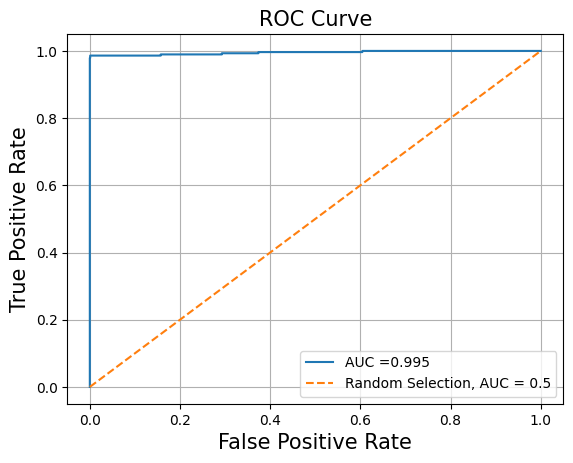

<Figure size 640x480 with 0 Axes>

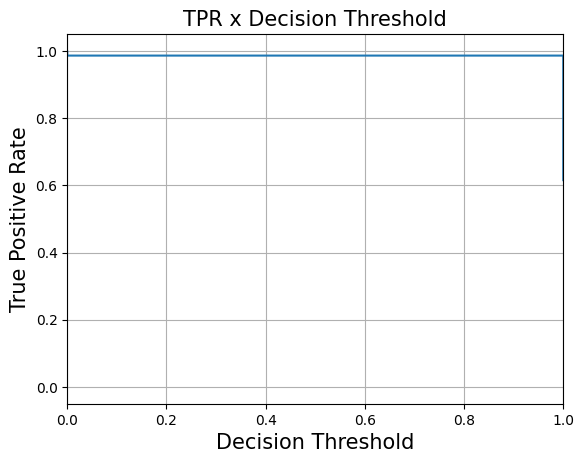

<Figure size 640x480 with 0 Axes>

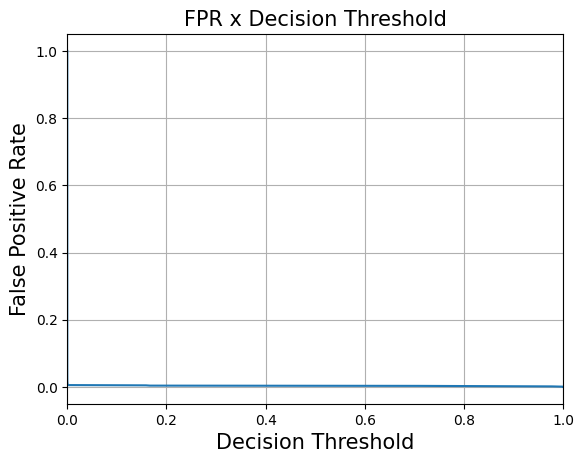


 Melhor Decision Threshold:  0.9999764

 Melhor Índice de Youden:  0.9853322949117342


<Figure size 640x480 with 0 Axes>

In [49]:
BestThreshold = AnalysisPlots(classes, Predictions)

In [50]:
# Incluindo informacao do tecido sobre as predicoes
TestInfos = pd.read_csv("/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Processed/TissueClassification/{}/TestLabels.csv".format(ExperimentName))
TestInfos = TestInfos[TestInfos['Unnamed: 0'].isin(filenames)]
TestInfos.sort_values('Unnamed: 0', inplace=True)

# Saving Final predictions
DL_Results = pd.DataFrame({'ImageID':filenames, 'Pred':Predictions, 'Class':classes})
DL_Results.sort_values('ImageID', inplace=True)
DL_Results['Types'] = TestInfos['Types'].values

DL_Results.to_csv(PATHFinalExperiment+"/DL_Prediction.csv", index=False, encoding='utf-8')
DL_Results

,ImageID,Pred,Class,Types
574,1,2.662664e-17,0,Breast
357,4,7.230061e-17,0,Breast
240,11,1.507560e-14,0,Breast
470,16,2.709202e-16,0,Breast
903,19,3.893931e-18,0,Breast
...,...,...,...,...
296,7865,1.000000e+00,1,Colon
1098,7876,1.000000e+00,1,Colon
901,7879,1.000000e+00,1,Colon
1308,7887,1.000000e+00,1,Colon


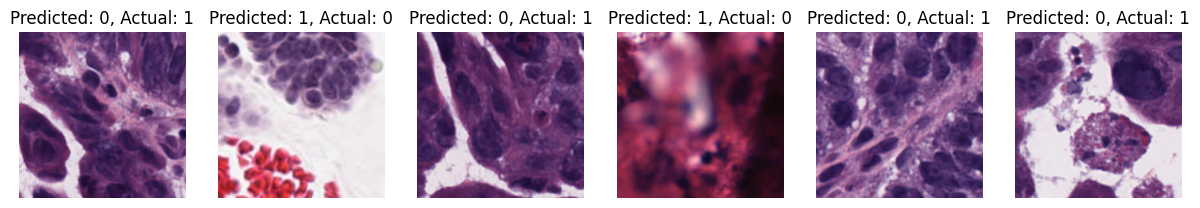

In [51]:
# Visualizando erros cometidos pelo modelo
VisualizeErrors(incorrect_images, incorrect_predictions, correct_labels, num_images=6)

## Análise de qual tecido foi mais difícil de acertar

In [34]:
from collections import Counter

Classification = DL_Results.copy()

# Classificação baseada no melhor valor de decision threshold obtido via Youden Index!
Classification.loc[Classification["Pred"]>=BestThreshold, "Pred"] = 1
Classification.loc[Classification["Pred"]<BestThreshold, "Pred"] = 0

# Selecionando apenas as linhas com predicoes incorretas
Classification = Classification.loc[Classification["Pred"]!=Classification["Class"]]

print('Quantidade de imagens classificadas incorretamente: ', len(Classification))

Quantidade de imagens classificadas incorretamente:  6


In [35]:
# Contando os tipos de cada tecido
TypesTotal = Counter(DL_Results['Types'])
TypesTotal

Counter({'Breast': 470,
         'Colon': 288,
         'Lung': 36,
         'Kidney': 26,
         'Prostate': 35,
         'Bladder': 29,
         'Stomach': 29,
         'Ovarian': 29,
         'Esophagus': 84,
         'Pancreatic': 39,
         'Uterus': 37,
         'Thyroid': 45,
         'Skin': 37,
         'Cervix': 58,
         'Adrenal_gland': 87,
         'Bile-duct': 84,
         'Testis': 39,
         'HeadNeck': 76,
         'Liver': 44})

# Multiclass classification

## Carregando dados

In [62]:
# Data augmentation and normalization for training

size = 224 # tamanho de entrada da EfficientNet B1

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10, shuffle=True, num_workers=2) for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Nclasses = len(class_names)
print(Nclasses)

19


## Carregando modelo

In [63]:
# Código que carrega melhor rede neural

# Define your model
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=Nclasses)

# Add a softmax activation to the output layer
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.to(device)

# Load your saved model
ModelPATH = subpath+'/Trained_DLModel.pt'
model.load_state_dict(torch.load(ModelPATH, map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [78]:
# Read the CSV file
df = pd.read_csv('/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/'+"Interim/ClassAndTypes.csv")

# Safeguards for corrupted files
CorruptedIndices = list(np.arange(7526, 7538,1))
df = df[~df['Unnamed: 0'].isin(CorruptedIndices)]

# Group the images by tissue type
groups = df.groupby("Types")
ClassesNames_0 = []
for i, group in groups:
  ClassesNames_0.append(i)

ClassesNames = []
print('Class order: \n')
for i in class_names:
  print(ClassesNames_0[int(i)])
  ClassesNames.append(str(ClassesNames_0[int(i)]))

Class order: 

Adrenal_gland
Bile-duct
Lung
Ovarian
Pancreatic
Prostate
Skin
Stomach
Testis
Thyroid
Uterus
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver


In [79]:
# Predicoes:
outputs, labels = Test_Multiclass(model, dataloaders)

Output:  tensor([[3.2689e-10, 2.6392e-12, 6.3135e-11,  ..., 3.6235e-08, 3.2428e-11,
         2.7092e-10],
        [1.4447e-07, 2.9104e-08, 1.7250e-08,  ..., 1.1233e-07, 1.1346e-09,
         5.9688e-09],
        [5.1967e-04, 6.4985e-05, 2.7000e-04,  ..., 4.8491e-05, 2.8124e-07,
         7.4429e-01],
        ...,
        [1.0936e-07, 2.4264e-04, 3.2509e-04,  ..., 2.2831e-06, 4.6388e-07,
         2.4230e-07],
        [2.3567e-09, 1.0000e+00, 1.0574e-10,  ..., 3.8180e-10, 3.6413e-12,
         7.9726e-09],
        [5.7217e-19, 1.2858e-18, 1.1851e-21,  ..., 2.8845e-17, 9.5251e-22,
         2.7928e-19]])
Labels:  tensor([14, 15, 18,  ...,  4,  1, 12])


In [80]:
import torchmetrics
from torchmetrics.functional.classification import multiclass_accuracy, multiclass_precision, multiclass_confusion_matrix, multiclass_f1_score
from torchmetrics.functional.classification import multiclass_roc


NClasses=19

# Confusion Matrix
CM = multiclass_confusion_matrix(outputs, labels, num_classes=NClasses)

# Accuracy
acc_normal = multiclass_accuracy(outputs, labels, num_classes=NClasses, average='micro') # acuracia normal
acc_perclass = multiclass_accuracy(outputs, labels, num_classes=NClasses, average=None).cpu().detach().numpy() # acuracia por classe

# Precision
PrecisionGeneral = multiclass_precision(outputs, labels, num_classes=NClasses)
Precision_perclass = multiclass_precision(outputs, labels, num_classes=NClasses, average=None).cpu().detach().numpy()

# F1 Score
F1ScoreGeneral = multiclass_f1_score(outputs, labels, num_classes=NClasses)
F1ScoreGeneral_perclass = multiclass_f1_score(outputs, labels, num_classes=NClasses, average=None).cpu().detach().numpy()

# ROC Curve
#fpr, tpr, thresholds = multiclass_roc(outputs, labels, num_classes=NClasses, thresholds=None)

In [95]:
#Classes = ['Adrenal_gland', 'Bile-duct', 'Breast', 'Colon', 'Esophagus', 'HeadNeck']
#Classes = ['Breast','Colon','Lung','Kidney','Prostate','Bladder','Stomach','Ovarian','Esophagus','Pancreatic','Uterus','Thyroid','Skin','Cervix','Adrenal_gland','Bile-duct','Testis','HeadNeck','Liver']
print('Confusion matrix: \n', CM)
print('General accuracy: ', acc_normal)
print('General precision: ', PrecisionGeneral)
print('General F1 score: ', F1ScoreGeneral)
print('\n')

count = 0
digts = 4

for i in ClassesNames:

  print('{}'.format(i))
  print('Per class accuracy: ', round(acc_perclass[count], digts))
  print('Per class precision: ', round(Precision_perclass[count], digts))
  print('Per class F1 score: ', round(F1ScoreGeneral_perclass[count], digts))
  print('-------------------------')
  count = count+1


Confusion matrix: 
 tensor([[ 87,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  0,  83,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
           0,   0,   0,   0,   0],
        [  0,   1,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  0,   1,   0,  27,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  0,   0,   0,   1,  37,   0,   0,   0,   0,   0,   0,   0,   0,   1,
           0,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0,  33,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  33,   0,   0,   0,   0,   0,   3,   0,
           0,   0,   0,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,  29,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0,  37,   0,   0,   0,

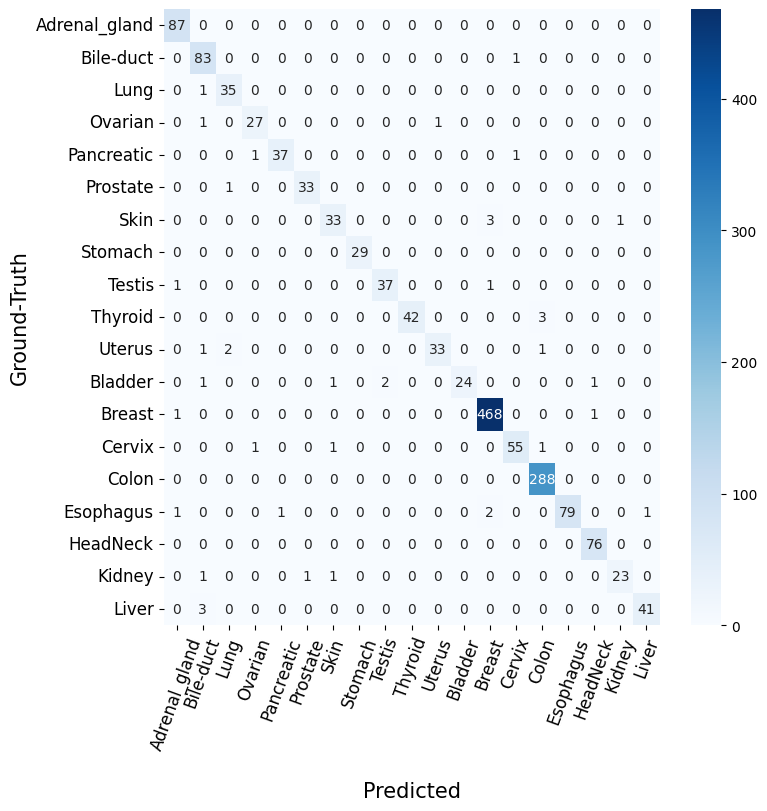

In [105]:
# Pretty CM
import seaborn as sns

plt.figure(figsize=(8,8))
ax = sns.heatmap(CM.cpu().detach().numpy(), annot=True, cmap='Blues', fmt=',d')

ax.set_xlabel('\nPredicted', fontsize=15)
ax.set_ylabel('Ground-Truth', fontsize=15);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(ClassesNames, rotation=70, fontsize=12)
ax.yaxis.set_ticklabels(ClassesNames, rotation=0, fontsize=12)

## Display the visualization of the Confusion Matrix.
plt.savefig(PATHFinalExperiment+'/CM.png', bbox_inches='tight')
plt.show()

In [99]:
# Classification report
from sklearn.metrics import classification_report

_, preds = torch.max(outputs, 1)

# Convert to numpy arrays:

y_pred = preds.cpu().detach().numpy()
y_test = labels.cpu().detach().numpy()

print(classification_report(y_test, y_pred, digits=4, target_names=ClassesNames))

               precision    recall  f1-score   support

Adrenal_gland     0.9667    1.0000    0.9831        87
    Bile-duct     0.9121    0.9881    0.9486        84
         Lung     0.9211    0.9722    0.9459        36
      Ovarian     0.9310    0.9310    0.9310        29
   Pancreatic     0.9737    0.9487    0.9610        39
     Prostate     0.9706    0.9706    0.9706        34
         Skin     0.9167    0.8919    0.9041        37
      Stomach     1.0000    1.0000    1.0000        29
       Testis     0.9487    0.9487    0.9487        39
      Thyroid     1.0000    0.9333    0.9655        45
       Uterus     0.9706    0.8919    0.9296        37
      Bladder     1.0000    0.8276    0.9057        29
       Breast     0.9873    0.9957    0.9915       470
       Cervix     0.9649    0.9483    0.9565        58
        Colon     0.9829    1.0000    0.9914       288
    Esophagus     1.0000    0.9405    0.9693        84
     HeadNeck     0.9744    1.0000    0.9870        76
       Ki

In [103]:
Report = classification_report(y_test, y_pred, digits=4, target_names=ClassesNames, output_dict=True)
ReportDF = pd.DataFrame(Report).transpose()
ReportDF.iloc[:-3,:].to_csv(PATHFinalExperiment+"/MetricsReport.csv", index=True, encoding='utf-8')
ReportDF.iloc[:-3,:]

,precision,recall,f1-score,support
Adrenal_gland,0.966667,1.000000,0.983051,87.0
Bile-duct,0.912088,0.988095,0.948571,84.0
Lung,0.921053,0.972222,0.945946,36.0
Ovarian,0.931034,0.931034,0.931034,29.0
Pancreatic,0.973684,0.948718,0.961039,39.0
Prostate,0.970588,0.970588,0.970588,34.0
Skin,0.916667,0.891892,0.904110,37.0
Stomach,1.000000,1.000000,1.000000,29.0
Testis,0.948718,0.948718,0.948718,39.0
Thyroid,1.000000,0.933333,0.965517,45.0
